In [1]:
import pickle
with open('/kaggle/input/takeo-data/New_I.pkl', 'rb') as f:
    X = pickle.load(f)

with open('/kaggle/input/takeo-data/New_Y.pkl', 'rb') as f:
    Y = pickle.load(f)


In [2]:
import numpy as np
Y = Y.astype(np.float32)

In [3]:
import cv2
import numpy as np
from tensorflow.keras.applications.inception_v3 import preprocess_input 
from tensorflow.image import resize

# Supondo que X seja uma lista de imagens coloridas.
X_resized = np.array([resize(image, [100, 100]) for image in X])
imagens_cinza = np.array([cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2GRAY) for image in X_resized])

def converter_para_rgb(imagens_cinza):
    imagens_rgb = np.stack((imagens_cinza,) * 3, axis=-1)
    return imagens_rgb

imagens_rgba = converter_para_rgb(imagens_cinza)


imagens_rgba[0].shape
#X = preprocess_input(imagens_rgba)
X = imagens_rgba
X.shape


# Convertendo a lista em um array NumPy
X = np.array(X)

2024-07-19 16:42:50.270284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 16:42:50.270422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 16:42:50.415761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
print(np.min(X))
print(np.max(X))
X.shape

0
255


(10022, 100, 100, 3)

In [5]:
X = preprocess_input(X)

In [6]:
print(np.min(X))
print(np.max(X))
X.shape

-1.0
1.0


(10022, 100, 100, 3)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [8]:
import numpy as np

unique, counts = np.unique(Y_train, return_counts=True)
ocorrencias = dict(zip(unique, counts))
print("Distribuição no conjunto de treino")
print(ocorrencias)

unique, counts = np.unique(Y_test, return_counts=True)
ocorrencias = dict(zip(unique, counts))

print("Distribuição no conjunto de teste")
print(ocorrencias)

Distribuição no conjunto de treino
{0.0: 6330, 1.0: 1687}
Distribuição no conjunto de teste
{0.0: 1593, 1.0: 412}


In [9]:
import os
import cv2
import albumentations as A
from skimage.io import imread, imsave
from pathlib import Path

# transformações
import albumentations as A

transformacoes = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=40, p=1),
    A.HorizontalFlip(p=0.5),
])



novas = 3

index = 0
labels = []
x_train = []

for arquivo in X_train:
    imagem = arquivo
    holder = Y_train[index]
    index += 1
    for i in range(novas):
        imagem_transformada = transformacoes(image=imagem)['image']
        labels.append(holder)
        x_train.append(imagem_transformada)
        
import numpy as np


X_train = np.array(x_train)  
Y_train = np.array(labels)  


In [10]:
import numpy as np

unique, counts = np.unique(Y_train, return_counts=True)
ocorrencias = dict(zip(unique, counts))
print("Distribuição no conjunto de treino")

print(ocorrencias)

unique, counts = np.unique(Y_test, return_counts=True)
ocorrencias = dict(zip(unique, counts))

print("Distribuição no conjunto de teste")
print(ocorrencias)

Distribuição no conjunto de treino
{0.0: 18990, 1.0: 5061}
Distribuição no conjunto de teste
{0.0: 1593, 1.0: 412}


In [11]:
# Criando o objeto StratifiedKFold para 3 folds
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Dicionário para armazenar os dados de treino de cada fold
folds = {}

# Dividindo os dados em folds
for i, (train_index, _) in enumerate(kfold.split(X_train, Y_train)):
    folds[f'x_train_{i+1}'] = X_train[train_index]
    folds[f'y_train_{i+1}'] = Y_train[train_index]

# Agora você tem x_train_1, y_train_1, x_train_2, y_train_2, x_train_3, y_train_3 armazenados no dicionário `folds`
x_train_1, y_train_1 = folds['x_train_1'], folds['y_train_1']
x_train_2, y_train_2 = folds['x_train_2'], folds['y_train_2']
x_train_3, y_train_3 = folds['x_train_3'], folds['y_train_3']

In [12]:
import numpy as np

unique, counts = np.unique(y_train_1, return_counts=True)
ocorrencias = dict(zip(unique, counts))
print("Distribuição no FOLD 1")
print(ocorrencias)

unique, counts = np.unique(y_train_2, return_counts=True)
ocorrencias = dict(zip(unique, counts))

print("Distribuição no FOLD 2")
print(ocorrencias)

unique, counts = np.unique(y_train_3, return_counts=True)
ocorrencias = dict(zip(unique, counts))

print("Distribuição no FOLD 3")
print(ocorrencias)

Distribuição no FOLD 1
{0.0: 12660, 1.0: 3374}
Distribuição no FOLD 2
{0.0: 12660, 1.0: 3374}
Distribuição no FOLD 3
{0.0: 12660, 1.0: 3374}


In [13]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3

def create_InceptionV3():
    base_model = InceptionV3(input_shape=(100, 100, 3), include_top=False, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [14]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
import numpy as np
import time
import tensorflow as tf

scores = []
tempo = []
historys = []
metricas_por_fold = []
melhor_model = None
melhor_f1_score = 0

if(True):
    start_time = time.time()
    tf.keras.backend.clear_session()
    
    n_splits = 3
    hist = []
    holder = []
    metricas_fold = []
    
    #kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    
    
       
    i =0
    for train_idx, val_idx in kfold.split(X_train, Y_train):
        tf.keras.backend.clear_session()
        early_stopping = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='min', restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, verbose=1, mode='min', min_lr=1e-5)
        modelo = create_InceptionV3()
        X_train_fold, Y_train_fold = X_train[train_idx], Y_train[train_idx]
        X_val_fold, Y_val_fold = X_train[val_idx], Y_train[val_idx]
        
        history = modelo.fit(X_train_fold, Y_train_fold, epochs=30, validation_data=(X_val_fold, Y_val_fold), callbacks=[early_stopping, reduce_lr])
        holder.append(modelo.evaluate(X_val_fold, Y_val_fold, verbose=0))

        # Previsão e cálculo das métricas para o conjunto de validação
        previsoes_val = modelo.predict(X_val_fold)
        previsoes_binarias_val = [1 if x > 0.5 else 0 for x in previsoes_val]
        
        # Relatório de Classificação para o conjunto de validação
        relatorio_dict = classification_report(Y_val_fold, previsoes_binarias_val, target_names=["Classe 0", "Classe 1"], output_dict=True)
        precision_val = relatorio_dict['macro avg']['precision']
        recall_val = relatorio_dict['macro avg']['recall']
        f1_val = relatorio_dict['macro avg']['f1-score']
        
        print("Relatório de Classificação (Validação):\n", classification_report(Y_val_fold, previsoes_binarias_val, target_names=["Classe 0", "Classe 1"]))
        print(f"F1: {f1_val:.4f}, Recall: {recall_val:.4f}, Precision: {precision_val:.4f}")
        metricas_fold.append((f1_val, recall_val, precision_val))
        
        

        # Verificar se este é o melhor modelo com base no F1-score
        if f1_val > melhor_f1_score:
            melhor_f1_score = f1_val
            melhor_model = modelo 
            bf = i
        i+=1
        del modelo
    # Guardar histórico e métricas
    hist.append(history)
    historys.append(hist)
    metricas_por_fold.append(metricas_fold)
    
    end_time = time.time()
    tempo.append(end_time - start_time)
    scores.append(holder)

# Exibir as métricas por fold e por fase
print(metricas_por_fold)


Epoch 1/30
  7/502 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5423 - loss: 0.9290  

I0000 00:00:1721407434.606097     826 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


502/502 ━━━━━━━━━━━━━━━━━━━━ 64s 80ms/step - accuracy: 0.7029 - loss: 0.6071 - val_accuracy: 0.7963 - val_loss: 0.4441 - learning_rate: 0.0010
Epoch 2/30
  7/502 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6888 - loss: 0.5382

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.7877 - loss: 0.4491 - val_accuracy: 0.8032 - val_loss: 0.4241 - learning_rate: 0.0010
Epoch 3/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.7965 - loss: 0.4338 - val_accuracy: 0.7998 - val_loss: 0.4295 - learning_rate: 0.0010
Epoch 4/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8012 - loss: 0.4193 - val_accuracy: 0.7999 - val_loss: 0.4262 - learning_rate: 0.0010
Epoch 5/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8045 - loss: 0.4125 - val_accuracy: 0.8038 - val_loss: 0.4246 - learning_rate: 0.0010
Epoch 6/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8148 - loss: 0.3958 - val_accuracy: 0.7938 - val_loss: 0.4329 - learning_rate: 0.0010
Epoch 7/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8226 - loss: 0.3872 - val_accuracy: 0.8048 - val_loss: 0.4289 - learning_rate: 0.0010
Epoch 8/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.8235 - loss: 0.3879

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.7909 - loss: 0.4606 - val_accuracy: 0.7946 - val_loss: 0.4377 - learning_rate: 0.0010
Epoch 3/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.8048 - loss: 0.4298 - val_accuracy: 0.8018 - val_loss: 0.4323 - learning_rate: 0.0010
Epoch 4/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.8047 - loss: 0.4186 - val_accuracy: 0.7987 - val_loss: 0.4416 - learning_rate: 0.0010
Epoch 5/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8125 - loss: 0.4051 - val_accuracy: 0.7926 - val_loss: 0.4349 - learning_rate: 0.0010
Epoch 6/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.8161 - loss: 0.3960 - val_accuracy: 0.7997 - val_loss: 0.4416 - learning_rate: 0.0010
Epoch 7/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.8141 - loss: 0.3968 - val_accuracy: 0.7872 - val_loss: 0.4415 - learning_rate: 0.0010
Epoch 8/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.8210 - loss: 0.3843

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


502/502 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.7914 - loss: 0.4537 - val_accuracy: 0.8004 - val_loss: 0.4390 - learning_rate: 0.0010
Epoch 3/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.8073 - loss: 0.4216 - val_accuracy: 0.7941 - val_loss: 0.4317 - learning_rate: 0.0010
Epoch 4/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.8097 - loss: 0.4138 - val_accuracy: 0.7946 - val_loss: 0.4362 - learning_rate: 0.0010
Epoch 5/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.8139 - loss: 0.4029 - val_accuracy: 0.7996 - val_loss: 0.4320 - learning_rate: 0.0010
Epoch 6/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.8160 - loss: 0.4002 - val_accuracy: 0.8017 - val_loss: 0.4371 - learning_rate: 0.0010
Epoch 7/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.8164 - loss: 0.3915 - val_accuracy: 0.7872 - val_loss: 0.4518 - learning_rate: 0.0010
Epoch 8/30
502/502 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.8219 - loss: 0.3879

In [15]:
ScoreM1 = []

for i in range(1):
    holder = []
    for j in range(3):
       holder.append(scores[i][j][1])
    ScoreM1.append(np.mean(holder))
    print("média ", (i+1), "acc: ", (np.mean(holder)))

print("média final: ", (np.mean(ScoreM1)))

média  1 acc:  0.7733981808026632
média final:  0.7733981808026632


In [16]:
model = melhor_model

In [17]:
TempoM1 = []

for i in range(1):
    holder = []
    for j in range(3):
       holder.append(tempo[i])
    TempoM1.append(np.mean(holder))
    print("média ", (i+1), "acc: ", (np.mean(holder)))

print("média final: ", (np.mean(TempoM1)))

média  1 acc:  1535.691731929779
média final:  1535.691731929779


In [18]:
model.save_weights('/kaggle/working/ResNet50-cross-10x.weights.h5')

Forma de X_test: (2005, 100, 100, 3)
Forma de Y_test: (2005,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step
Forma das previsões: (2005, 1)
Acurácia no conjunto de teste: 0.7790523690773067
Matriz de Confusão:
 [[1399  194]
 [ 249  163]]


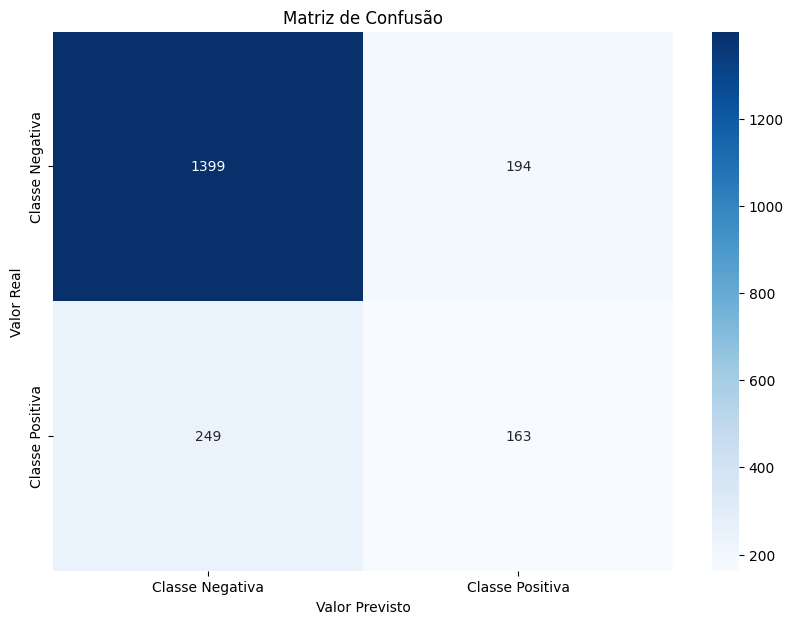

Relatório de Classificação:
               precision    recall  f1-score   support

    Classe 0       0.85      0.88      0.86      1593
    Classe 1       0.46      0.40      0.42       412

    accuracy                           0.78      2005
   macro avg       0.65      0.64      0.64      2005
weighted avg       0.77      0.78      0.77      2005



In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Certifique-se de que X_test e Y_test tenham a forma correta
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de Y_test: {Y_test.shape}")

# Verifique se X_test não está vazio
if X_test.size == 0:
    raise ValueError("X_test está vazio")

# Realize a predição
previsoes = model.predict(X_test)

# Verifique a forma das previsões
print(f"Forma das previsões: {previsoes.shape}")

# Converta as previsões para binário
previsoes_binarias = [1 if x > 0.5 else 0 for x in previsoes]

# Avaliação da acurácia
acuracia = accuracy_score(Y_test, previsoes_binarias)
print(f"Acurácia no conjunto de teste: {acuracia}")

# Matriz de Confusão
matriz_confusao = confusion_matrix(Y_test, previsoes_binarias)
print("Matriz de Confusão:\n", matriz_confusao)

# Plot da Matriz de Confusão
plt.figure(figsize=(10, 7))
sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe Negativa", "Classe Positiva"], yticklabels=["Classe Negativa", "Classe Positiva"])
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.show()

# Relatório de Classificação
relatorio_classificacao = classification_report(Y_test, previsoes_binarias, target_names=["Classe 0", "Classe 1"])
print("Relatório de Classificação:\n", relatorio_classificacao)


In [20]:
# Exibindo todas as métricas salvas para cada fold e fase
for fase, metricas_fase in enumerate(metricas_por_fold, 1):
    print(f"Fase {fase}:")
    for fold, (f1, recall, precision) in enumerate(metricas_fase, 1):
        print(f"  Fold {fold}: F1-score = {f1:.4f}, Recall = {recall:.4f}, Precision = {precision:.4f}")

# Se você também deseja calcular e mostrar a média das métricas por fase e a média geral, pode fazer isso:
medias_f1 = []
medias_recall = []
medias_precision = []
print('                                                      ')    
print('                                                      ')
j =0
for metricas_fase in metricas_por_fold:
    print("fase: ", j+1)
    f1s = [f1 for f1, _, _ in metricas_fase]
    recalls = [recall for _, recall, _ in metricas_fase]
    precisions = [precision for _, _, precision in metricas_fase]
    
    media_f1_fase = np.mean(f1s)
    media_recall_fase = np.mean(recalls)
    media_precision_fase = np.mean(precisions)

    medias_f1.append(media_f1_fase)
    medias_recall.append(media_recall_fase)
    medias_precision.append(media_precision_fase)

    print(f"Média F1-score da fase: {media_f1_fase:.4f}")
    print(f"Média Recall da fase: {media_recall_fase:.4f}")
    print(f"Média Precision da fase: {media_precision_fase:.4f}")
    print('                                                      ')    
    print('                                                      ')
    j+=1

print(f"Média final F1-score: {np.mean(medias_f1):.4f}")
print(f"Média final Recall: {np.mean(medias_recall):.4f}")
print(f"Média final Precision: {np.mean(medias_precision):.4f}")


Fase 1:
  Fold 1: F1-score = 0.6599, Recall = 0.6592, Precision = 0.6606
  Fold 2: F1-score = 0.6543, Recall = 0.6431, Precision = 0.6729
  Fold 3: F1-score = 0.6535, Recall = 0.6637, Precision = 0.6466
                                                      
                                                      
fase:  1
Média F1-score da fase: 0.6559
Média Recall da fase: 0.6553
Média Precision da fase: 0.6600
                                                      
                                                      
Média final F1-score: 0.6559
Média final Recall: 0.6553
Média final Precision: 0.6600


In [21]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def train_model(model, X_train, Y_train, EPOCHS=25):
    # Usando 'val_accuracy' em vez de 'val_acc'
    early_stop = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1,
                               mode='max', restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5,
                                  verbose=1, mode='max', min_lr=1e-5)

    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size=16,
                        epochs=EPOCHS,
                        callbacks=[reduce_lr, early_stop])
    return history


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Importe a biblioteca NumPy

# Listas para armazenar as métricas de cada iteração
accuracies = []
precisions = []
recalls = []
f1_scores = []
historys = []
if(bf==0):
    treinox = x_train_1
    treinoy = y_train_1
    print("melor fold = 1")
elif(bf==1):
    treinox = x_train_2
    treinoy = y_train_2
    print("melor fold = 2")
else:
    treinox = x_train_3
    treinoy = y_train_3
    print("melor fold = 3")

for i in range(10):
    tf.keras.backend.clear_session()
    model = create_InceptionV3()
    historys.append(train_model(model, treinox, treinoy, 30))

    previsoes = model.predict(X_test)
    previsoes_binarias = [1 if x > 0.5 else 0 for x in previsoes]

    # Adiciona a acurácia à lista
    acuracia = accuracy_score(Y_test, previsoes_binarias)
    accuracies.append(acuracia)

    # Calcula e adiciona precisão, recall e f1-score à suas respectivas listas
    relatorio_classificacao = classification_report(Y_test, previsoes_binarias, target_names=["Classe 0", "Classe 1"], output_dict=True)
    # Capturando os valores individuais de precisão, recall e F1-score para a classe '1'
    precisao_classe_1 = relatorio_classificacao['macro avg']['precision']
    recall_classe_1 = relatorio_classificacao['macro avg']['recall']
    f1_score_classe_1 = relatorio_classificacao['macro avg']['f1-score']

    print(f"Precisão Classe 1: {precisao_classe_1}")
    print(f"Recall Classe 1: {recall_classe_1}")
    print(f"F1-Score Classe 1: {f1_score_classe_1}")

    precisions.append(precisao_classe_1)
    recalls.append(recall_classe_1)
    f1_scores.append(f1_score_classe_1)


# Calcula a média de cada métrica
acuracia_media = np.mean(accuracies)
precisao_media = np.mean(precisions)
recall_medio = np.mean(recalls)
f1_score_medio = np.mean(f1_scores)

# Calcula o desvio padrão de cada métrica
acuracia_dp = np.std(accuracies)
precisao_dp = np.std(precisions)
recall_dp = np.std(recalls)
f1_score_dp = np.std(f1_scores)

# Exibe os resultados
print(f"Acurácia média: {acuracia_media} ± {acuracia_dp}")
print(f"Precisão média: {precisao_media} ± {precisao_dp}")
print(f"Recall médio: {recall_medio} ± {recall_dp}")
print(f"F1-Score médio: {f1_score_medio} ± {f1_score_dp}")

# Opção para plotar a matriz de confusão da última iteração
cm = confusion_matrix(Y_test, previsoes_binarias)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

import matplotlib.pyplot as plt

# Configuração do gráfico de Acurácia
plt.figure(figsize=(14, 5))

# Gráfico de Acurácia por Época para cada history
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
for history in historys:
    plt.plot(history.history['accuracy'], label='Acurácia (treino)')
    plt.plot(history.history['val_accuracy'], label='Acurácia (validação)')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Configuração do gráfico de Loss
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
for history in historys:
    plt.plot(history.history['loss'], label='Loss (treino)')
    plt.plot(history.history['val_loss'], label='Loss (validação)')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()


melor fold = 1
Epoch 1/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 67s 54ms/step - accuracy: 0.6862 - loss: 0.6254 - val_accuracy: 0.7752 - val_loss: 0.4704 - learning_rate: 0.0010
Epoch 2/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7901 - loss: 0.4663 - val_accuracy: 0.8095 - val_loss: 0.4283 - learning_rate: 0.0010
Epoch 3/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7936 - loss: 0.4400 - val_accuracy: 0.8057 - val_loss: 0.4294 - learning_rate: 0.0010
Epoch 4/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7925 - loss: 0.4393 - val_accuracy: 0.8023 - val_loss: 0.4389 - learning_rate: 0.0010
Epoch 5/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8043 - loss: 0.4269 - val_accuracy: 0.8070 - val_loss: 0.4321 - learning_rate: 0.0010
Epoch 6/30
802/802 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.7991 - loss: 0.4195 - val_accuracy: 0.8014 - val_loss: 0.4319 - learning_rate: 0.0010
Epoch 7/30
799/802 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accura

In [ ]:
model.save_weights('/kaggle/working/VGG-16.weights.h5')